In [1]:
import sys
sys.path.append('..')
import gdspy
import numpy as np
from importlib import reload
#import libraries.conformal_mapping as cm
#import libraries.general_design_functions as gdf
#import libraries.general_sample_creator as creator
#from  ..libraries import general_design_functions as gdf
#fr
from copy import deepcopy
from QCreator import elements
from QCreator import general_sample_creator as creator

In [2]:
tl_core = 20
tl_gap = 12
tl_ground = 10

resonator_core = 8
resonator_gap = 7
resonator_ground = 16

pad_offset = 1000
pad_element_offset = 1000

coupler_start = pad_offset + pad_element_offset
coupler_delta = 500
coupler_length = 300
num_couplers = 1

grounding_width = 1
reload(gdspy)
reload(creator)
reload(elements)

layers_configuration = {
    'total':0,
    'restricted area':10,
    'for removing':100,
    'JJs':1,
    'air bridges':2,
    'air bridge pads':3,
    'vertical gridlines':15,
    'horizontal gridlines':16,
    'inverted':20
}
sample = creator.Sample('4_qubits',layers_configuration)

#specify sample vertical and horizontal lengths
sample.chip_geometry.sample_vertical_size=4.7e3
sample.chip_geometry.sample_horizontal_size=9.7e3

central_line_y = sample.chip_geometry.sample_vertical_size/2

ChichkovAB = elements.AirBridge(width=15, 
                                length=60, 
                                padsize=30, 
                                min_spacing = 30,
                                layer_configuration=sample.layer_configuration)

chip_edge_ground = elements.ChipEdgeGround(sample.chip_geometry, sample.layer_configuration, sample.pads)
sample.add(chip_edge_ground)

grid_ground = elements.GridGround(sample.chip_geometry, sample.layer_configuration, sample.objects, 
                                  width=4, period=500)
sample.add(grid_ground)

# 1. Create contact pads:

p1 = elements.Pad('p1', (pad_offset,  central_line_y), np.pi, tl_core, tl_gap, tl_ground, 
                  layer_configuration=sample.layer_configuration, chip_geometry=sample.chip_geometry, 
                  **elements.default_pad_geometry())
p2 = elements.Pad('p2', (sample.chip_geometry.sample_horizontal_size-pad_offset,  central_line_y), 
                  0, tl_core, tl_gap, tl_ground, 
                  layer_configuration=sample.layer_configuration, chip_geometry=sample.chip_geometry, 
                  **elements.default_pad_geometry())
sample.add(p1)
sample.add(p2)
# 2. Create main coupler
main_coupler = elements.CPWCoupler(name='TL-resonator coupler',
                                   points=[(coupler_start, central_line_y), (coupler_start+coupler_length, central_line_y)],
                                   w=[resonator_core, resonator_ground, tl_core],
                                   s=[resonator_gap, resonator_gap, tl_gap, tl_gap],
                                   g=tl_ground,
                                   layer_configuration=sample.layer_configuration, r=100)
sample.add(main_coupler)

# 3. Create fanout to create closed end of resonator
fanout_for_closed_end = sample.fanout(o=main_coupler, port='port1', name='closed end resonator fanout', grouping=[1,3])

# 4. Create grounding for fanout closed end
g1 = sample.ground(o=fanout_for_closed_end, port='center', name='cl1', grounding_width=grounding_width, grounding_between = [(2,3)])


#5. Create a ground end for resonator

resonator_ground = elements.RectGrounding(name='ground of resonator', position = (1989.0, 899.0), orientation= -1.571, w=8, s=7,
                 g=10, grounding_width=grounding_width, grounding_between=[(0,2)],
                 layer_configuration=sample.layer_configuration)

sample.add(resonator_ground)

#5. Create a meander from coupler to resonator ground

resonator_meander = sample.connect_cpw(name='resonator meander', o1=fanout_for_closed_end, port1='up', o2=resonator_ground,
                           port2='wide', points=[(2202, 1917), (1502, 2002)])

#6. Create fanout for open end
fanout_for_open_end = sample.fanout(o=main_coupler, port='port2', name='open end resonator fanout', grouping=[1, 3])

#7.Create grounding for fanout openend
g2 = sample.ground(o=fanout_for_open_end, port='center', name='cl2', grounding_width=10, grounding_between = [(0,1)])

#8. Create open end
open_end = elements.OpenEnd(name='open end',position=(2500,1729.0),
                            w=[resonator_core],
                            s=[resonator_gap, resonator_gap],
                            g=tl_ground,
                            orientation=-np.pi/2,
                            layer_configuration=sample.layer_configuration,
                            h1=20,
                            h2=10)
sample.add(open_end)

#9. Create a meander from coupler to resonator ground

resonator_open_end = sample.connect_cpw(name='open end', o1=fanout_for_open_end, port1='down', o2=open_end,
                           port2='wide', points=[])
#10. Create left and right TL to ports
left_TL = sample.connect_cpw(o1=p1, o2=g1, port1='port', port2='narrow', name='left TL', points=[])
right_TL = sample.connect_cpw(o1=p2, o2=g2, port1='port', port2='narrow', name='right TL', points=[])

In [3]:
design = sample.draw_design()
sample.watch()

/home/alena/anaconda3/lib/python3.7/site-packages/gdspy/path.py:828: UserWarning: [GDSPY] Possible inconsistency found in `FlexPath` due to sharp corner.
  "[GDSPY] Possible inconsistency found in "


In [11]:
sample.write_to_gds()

Gds file has been writen here:  /home/alena/QCreator/example_notebooks\4_qubits.gds


In [24]:
resonator_open_end.length

610.8072309317841

In [25]:
resonator_meander.cm()

(array([[1.4656185e-16]]), array([[4.72581822e-13]]))

In [7]:
main_coupler.length

299.7979999326667

In [8]:
fanout_for_closed_end.finilize_points_for_tls()

{'coupler': {'l': 11.0,
  'w': [8, 16, 20],
  's': [7, 7, 12, 12],
  'g': 10,
  'noc': 3},
 'center': {'l': 11.0, 'w': [20, 16], 's': [12, 12, 7], 'g': 10, 'noc': 2},
 'up': {'l': 21.0, 'w': [8], 's': [7, 7], 'g': 10, 'noc': 1}}

In [9]:
fanout_for_open_end.finilize_points_for_tls()

{'coupler': {'l': 11.0,
  'w': [8, 16, 20],
  's': [7, 7, 12, 12],
  'g': 10,
  'noc': 3},
 'center': {'l': 11.0, 'w': [16, 20], 's': [7, 12, 12], 'g': 10, 'noc': 2},
 'down': {'l': 21.0, 'w': [8], 's': [7, 7], 'g': 10, 'noc': 1}}

# Topology for https://smm.misis.ru/

In [10]:
'''
coupler w = [20, 16, 18], s = [12, 12, 7, 7], l = 299 + 11 + 11
closed end: l = 2411 + 21
open end: l = 610.8 + 21
'''

'\ncoupler w = [20, 16, 18], s = [12, 12, 7, 7], l = 299 + 11 + 11\nclosed end: l = 2411 + 21\nopen end: l = 610.8 + 21\n'

In [11]:
resonator_open_end.length

610.8072309317841

In [4]:
sys, connections, elements_ = sample.get_tls()

In [5]:
sys.elements[5].l

2.75

In [6]:
sys.terminal_node_mapping

[[0],
 [15],
 [17],
 [1, 2, 3, 8, 9, 10],
 [1, 2, 3, 19, 20, 21],
 [19, 20, 4, 5],
 [21, 6],
 [5, 0],
 [4, 16],
 [7],
 [6, 7],
 [8, 9, 10, 22, 23, 24],
 [22, 23, 12, 11],
 [24, 13],
 [11, 0],
 [12, 18],
 [14, 0],
 [13, 14],
 [15, 16],
 [17, 18]]

In [4]:
for elem in range(len(sys.elements)):
    print(sys.elements[elem], sys.terminal_node_mapping[elem])

Short  [0]
Port p1 [15]
Port p2 [17]
TL TL-resonator coupler (n=3) [1, 2, 3, 8, 9, 10]
TL closed end resonator fanout_coupled_line_0 (n=3) [1, 2, 3, 19, 20, 21]
TL closed end resonator fanout_line_1 (n=2) [19, 20, 4, 5]
TL closed end resonator fanout_line_2 (n=1) [21, 6]
R cl10 [5, 0]
TL cl1 (n=1) [4, 16]
Short  [7]
TL resonator meander (n=1) [6, 7]
TL open end resonator fanout_coupled_line_0 (n=3) [8, 9, 10, 22, 23, 24]
TL open end resonator fanout_line_1 (n=2) [22, 23, 12, 11]
TL open end resonator fanout_line_2 (n=1) [24, 13]
R cl20 [11, 0]
TL cl2 (n=1) [12, 18]
C open_end [14, 0]
TL open end (n=1) [13, 14]
TL left TL (n=1) [15, 16]
TL right TL (n=1) [17, 18]


In [5]:
f, delta, modes = sys.get_modes()

In [6]:
f/(2*np.pi) / 1e9

array([7.93894710e+00, 8.69143586e+00, 1.62452942e+01, 1.99137829e+01,
       2.06746822e+01, 2.45724183e+01, 2.62152661e+01, 2.64018617e+01,
       2.64454456e+01, 3.11063460e+01, 3.11681783e+01, 4.41328265e+01,
       5.33839688e+01, 6.03454002e+01, 6.97140589e+01, 8.11686370e+01,
       8.11695888e+01, 8.14687339e+01, 8.30523809e+01, 8.30551419e+01,
       9.35890782e+01, 1.23868828e+02, 1.34852187e+02, 1.62735993e+02,
       1.67083229e+02, 1.71091365e+02, 1.72145689e+02, 1.75856404e+02,
       1.93455230e+02, 2.02522021e+02, 2.03117870e+02, 2.28505184e+02,
       2.67021873e+02, 2.76485552e+02, 2.95606471e+02, 3.20913384e+02,
       3.21020652e+02, 3.28507042e+02, 3.28656744e+02, 3.31800294e+02,
       3.65935728e+02, 3.83908293e+02, 4.69711521e+02, 4.97013254e+02,
       5.08652677e+02, 5.42910093e+02, 5.51087577e+02, 5.52814592e+02,
       5.67840188e+02, 5.72018238e+02, 6.31682488e+02, 6.48860391e+02,
       6.49159466e+02, 6.57153130e+02, 6.57236427e+02, 6.60874476e+02,
      

In [11]:
f[1]/(2*np.pi) / 1e9 # frequency in GHz

8.880727537493494

In [12]:
delta[1]/(2*np.pi) * 2 /1e6# decay rate in MHz

0.2949259142475769

In [22]:
Q = (f[1]/(2*np.pi)) / (delta[1]/(2*np.pi) * 2 )
Q # quality factor

30433.052668019303

../QCreator/general_sample_creator.py:378: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  s.append(np.linalg.lstsq(m, boundary)[0][a2[0]])


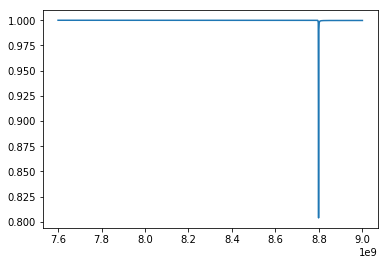

In [10]:
f_ = np.linspace(7.6e9, 9.0e9, 1001)
s21 = sample.get_s21('p1', 'p2', f_)
from matplotlib import pyplot as plt
plt.plot(f_, np.abs(s21))

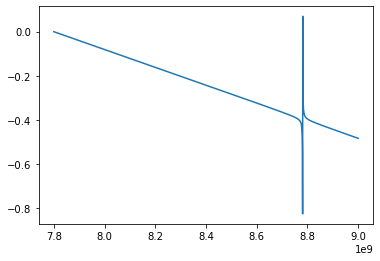

In [25]:
plt.plot(f_, np.angle(s21))

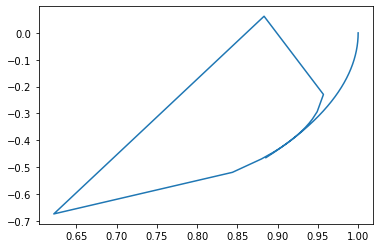

In [26]:
plt.plot(s21.real, s21.imag)

In [27]:
import resonator_tools
from resonator_tools.circuit import notch_port, reflection_port

ModuleNotFoundError: No module named 'resonator_tools'

In [43]:
fitter = notch_port(f_data=f_, z_data_raw=s21)

In [44]:
fitter.autofit()

In [45]:
fitter.fitresults

{'Qi_dia_corr': 1198095938.715782,
 'Qi_no_corr': -6852903.184310759,
 'absQc': 2706.0123598305254,
 'Qc_dia_corr': 2707.087424212836,
 'Ql': 2707.081307586006,
 'fr': 8870154347.400578,
 'theta0': -3.1134091184351247,
 'phi0': 0.028183535181023102,
 'chi_square': 9.801767279358804e-06,
 'delay': 6.540304863217369e-11,
 'a': 0.9996005334742273,
 'alpha': -3.064180206622535}